# MCMC samples from the true posterior for the CR model

Problem: Given an observed data set, generate MCMC samples from the posterior distribution.

Reason: This is needed in order to define a performance metric.

In [1]:
# Install dependencies
!pip install emcee corner --quiet

Traceback (most recent call last):
  File "c:\users\henry\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\henry\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\henry\anaconda3\Scripts\pip.exe\__main__.py", line 4, in <module>
ModuleNotFoundError: No module named 'pip'


In [10]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

In [3]:
%load_ext autoreload
%autoreload 2

In [48]:
# ODE model for conversion reaction 
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)
   
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

def batch_simulator_augment01(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and augmentation by zeros/ones
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.array([0,1,2])#np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, 0.0])  
        
    return sim_data

We build an amortized parameter estimation network.

In [5]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [50]:
n_params = 3
true_params = true_params[0:3,:]#prior(n_params) 
x_augment01 = batch_simulator_augment01(true_params, n_obs).astype(np.float32)

In [51]:
%%time
# "True" means via MCMC sampling
mcmc_means = np.empty((n_params, 2))

for i in range(n_params):
    present_timepoints = time_points[x_augment01[i,:,1]==1]
    present_data = x_augment01[i, x_augment01[i,:,1]==1, 0]
    
    def log_prior(x,y):   
        # Evaluates log-prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
        return norm.logpdf(x,-0.75,0.25) + norm.logpdf(y,-0.75,0.25)

    def log_likelihood(x,y):   
        # Calculates log-likelihood p(x_{1:N} | theta) by ignoring the missing data
        x = 10**x
        y = 10**y
        s = x + y
        b = x/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(present_timepoints)
        residual = (present_data - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return - nllh

    def log_posterior(x,y):   
        # Evaluates the unnormalized log-posterior probability p(theta | x_{1:N}) according to Bayes' formula
        return log_likelihood(x,y) + log_prior(x,y)

    def log_posterior_v(x: np.ndarray):
        """Log-posterior with a single vector-valued argument."""
        x, y = x
        return log_posterior(x, y)

    def sample(n_sample=10000, n_walker=10):
        """Perform sampling using emcee."""
        n_dim = 2
        p0 = np.random.randn(n_walker, n_dim)
        sampler = emcee.EnsembleSampler(n_walker, n_dim, log_posterior_v)
        sampler.run_mcmc(p0, n_sample)    
        samples = sampler.get_chain(flat=True)
        return samples

    # Sample
    samples = sample(n_sample=10000)
    
    # Posterior mean
    mcmc_means[i] = np.array([np.mean(samples[:, 0]), np.mean(samples[:, 1])])   

Wall time: 2min 5s


In [52]:
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=1000)
bayesflow_means = param_samples_augment01.mean(axis=1)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


In [53]:
params = np.c_[mcmc_means, bayesflow_means, true_params]
print(params)

[[-0.72455449 -0.75294824 -0.72911263 -0.75935644 -0.7206437  -0.76974463]
 [-1.08632731 -0.57762746 -1.09444797 -0.58394599 -1.14080679 -0.70397258]
 [-0.7532695  -0.74654883 -0.75063866 -0.75139052 -0.93124372 -0.58484286]]


In [49]:
n_params = 500
true_params = np.load("true_params.npy")
x_augment01 = np.load("x_augment01.npy")
mcmc_means = np.load("mcmc_means.npy")

In [21]:
# Augment by 0/1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=1000)
v_augment01 = bootstrap_metrics(np.swapaxes(param_samples_augment01, 0, 1), mcmc_means)
a1 = display_metrics(v_augment01)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
NRMSE(k_1): 0.171 ± 0.009
NRMSE(k_2): 0.133 ± 0.015
R²(k_1): 0.067 ± 0.097
R²(k_2): 0.179 ± 0.112


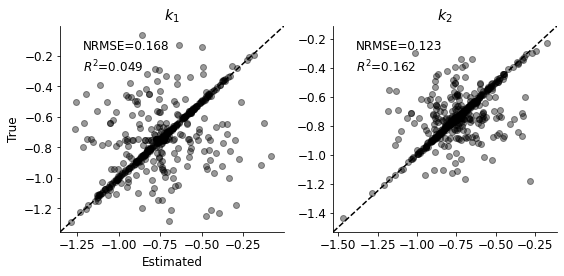

In [22]:
bayesflow_means = param_samples_augment01.mean(axis=1)
f = true_vs_estimated(mcmc_means, bayesflow_means, ['$k_1$', '$k_2$'])

In [23]:
params = np.c_[mcmc_means, bayesflow_means, true_params]
print(params)

[[-0.99583063 -0.69799158 -0.72394121 -0.77604431 -0.7206437  -0.76974463]
 [-0.61780436 -0.72040262 -1.03486073 -0.58747971 -1.14080679 -0.70397258]
 [-1.03251702 -0.58518638 -0.98671252 -0.68601406 -0.93124372 -0.58484286]
 ...
 [-0.58347735 -0.915851   -0.64840347 -0.61463457 -0.6223278  -0.58018827]
 [-0.64524623 -0.61317297 -0.58651286 -0.91783804 -0.67904675 -1.07686889]
 [-0.60292362 -1.16775269 -0.60704964 -1.17625749 -0.61173737 -1.16541636]]


In [14]:
# Insert -1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
x_insert = np.ones((n_params, n_obs, 1), dtype=np.float32)
for m in range(n_params):
    x_insert[m, :, 0] = x_augment01[m, :, 0]
param_samples_insert = amortizer.sample(x_insert, n_samples=1000)
v_insert = bootstrap_metrics(np.swapaxes(param_samples_insert, 0, 1), mcmc_means)
a2 = display_metrics(v_insert)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


NRMSE(k_1): 0.173 ± 0.010
NRMSE(k_2): 0.133 ± 0.014
R²(k_1): 0.050 ± 0.101
R²(k_2): 0.177 ± 0.099


In [ ]:
# Time labels
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)
# BayesFlow samples from the learned posterior
param_samples_timepoints = np.empty((n_params, 1000, 2), dtype=np.float32)
for m in range(n_params):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_timepoints = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_timepoints[0, :, 0] = x_augment01[m, present_indices, 0]
    x_timepoints[0, :, 1] = time_points[present_indices]
    param_samples_timepoints[m] = amortizer.sample(x_timepoints, n_samples=1000)
v_timepoints = bootstrap_metrics(np.swapaxes(param_samples_timepoints, 0, 1), mcmc_means)
a3 = display_metrics(v_timepoints)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


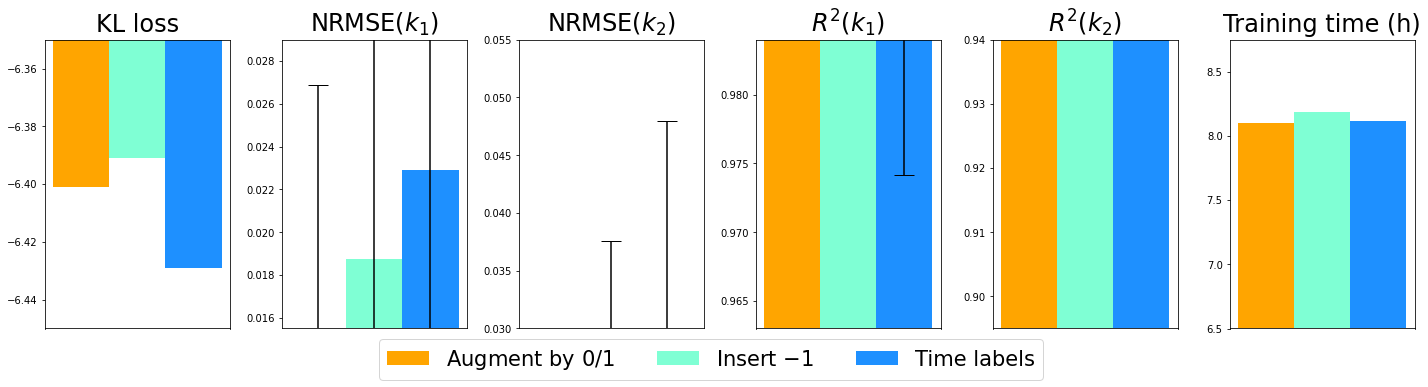

In [13]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
plt.rcParams['font.size'] = 15

bar_chart(ax, np.array([-6.401, -6.391, -6.429]), 0, 'KL loss', y_lim=np.array([-6.45, -6.35]))
bar_chart(ax, np.array([a1[0,0], a2[0,0], a3[0,0]]), 1, 'NRMSE$(k_1)$', 
          se=np.array([a1[1,0], a2[1,0], a3[1,0]]), y_lim=np.array([0.0155, 0.029]))
bar_chart(ax, np.array([a1[0,1], a2[0,1], a3[0,1]]), 2, 'NRMSE$(k_2)$', 
          se=np.array([a1[1,1], a2[1,1], a3[1,1]]), y_lim=np.array([0.030, 0.055]))
bar_chart(ax, np.array([a1[0,2], a2[0,2], a3[0,2]]), 3, '$R^2(k_1)$', 
          se=np.array([a1[1,2], a2[1,2], a3[1,2]]), 
          y_lim=np.array([0.963, 0.984]), y_ticks=np.array([0.965, 0.970, 0.975, 0.980]))
bar_chart(ax, np.array([a1[0,3], a2[0,3], a3[0,3]]), 4, '$R^2(k_2)$', 
          se=np.array([a1[1,3], a2[1,3], a3[1,3]]), 
          y_lim=np.array([0.895, 0.94]), y_ticks=np.array([0.90, 0.91, 0.92, 0.93, 0.94]))
bar_chart(ax, np.array([8+6/60, 8+11/60, 8+7/60]), 5, 'Training time (h)', 
          y_lim=np.array([6.5,8.75]), y_ticks=np.array([6.5, 7.0, 7.5, 8.0, 8.5]))

for axes in ax: 
    handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.11), ncol=4, fontsize=21)
plt.tight_layout()
plt.show()
#fig.savefig("figures/{}_bar_chart.png".format('CR3'), dpi=300, bbox_inches='tight')